##Moive Recommendation

In this notebook, I use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

## Part 0: Environment Setup

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
from mpl_toolkits.mplot3d import Axes3D

os.environ["PYSPARK_PYTHON"] = "python3"
#%matplotlib inline

## Part 1: Data ETL and Data Exploration

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

movies_df = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags_df = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [0]:
movies_df.show(5)
ratings_df.show(5)
links_df.show(5)
tags_df.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+-------+-------+------+
movieId| imdbId|tmdbId|
+-------+-------+------+
 1|0114709| 862|
 2|0113497| 8844|
 3|0113228| 15602|
 4|0114885| 31357|
 5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

+------+-------+---------------+----------+
userId|movieId| tag| timestamp|
+------+-------+---------------+----------+
 2| 60756| funny|1445714994|
 2| 60756|Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows

In [0]:
print("If there is missing data in each table?")
print('movie_df: {}'.format(movies_df.count() == movies_df.na.drop().count()))
print('ratings_df: {}'.format(ratings_df.count() == ratings_df.na.drop().count()))
print('links_df: {}'.format(links_df.count() == links_df.na.drop().count()))
print('tags_df: {}'.format(tags_df.count() == tags_df.na.drop().count()))

If there is missing data in each table?
movie_df: True
ratings_df: True
links_df: False
tags_df: True

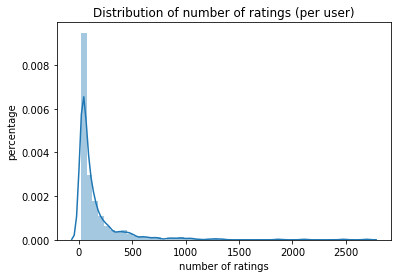

In [0]:
# get statistics for users
users_result = ratings_df.groupBy("userId").count()\
.orderBy('count', ascending=False)

fig = plt.figure()
tmp=sns.distplot(users_result.toPandas()['count'], hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per user)')
display(tmp)

In [0]:
users_result.toPandas().head(5)

Out[21]:

,userId,count
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346


In [0]:
users_result.toPandas().describe()

Out[22]:

,count
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


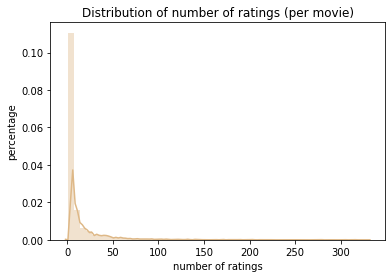

In [0]:
# get statistics for movies
movies_result=ratings_df.groupBy("movieId").count()\
.orderBy('count', ascending=False)

fig = plt.figure()
tmp=sns.distplot(movies_result.toPandas()['count'], color = 'burlywood', hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per movie)')
display(tmp)

In [0]:
movies_result.toPandas().head(5)

Out[24]:

,movieId,count
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278


In [0]:
movies_result.toPandas().describe()

Out[25]:

,count
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [0]:
# analysis movies by content
movies_genres_temp=movies_df.where('genres is not null')\
.select('title', F.explode(F.split('genres', '\|'))\
.alias('genres'))

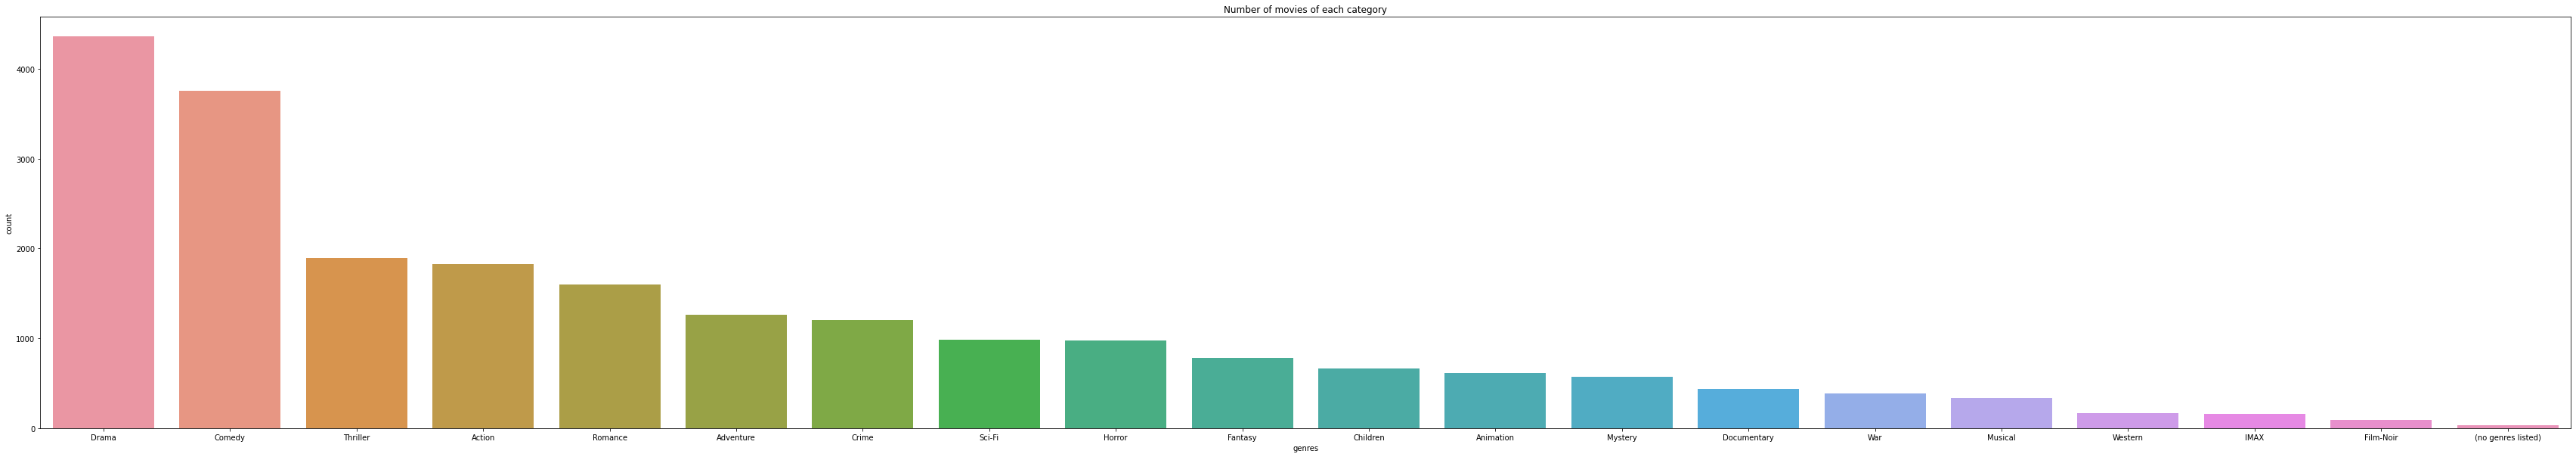

In [0]:
movies_genres=movies_genres_temp.groupBy('genres').count()\
.orderBy('count', ascending=False)\
.toPandas()

plt.figure(figsize=(60,10))
tmp=sns.barplot(x='genres', y='count', data=movies_genres)
tmp.set_title('Number of movies of each category')
display(tmp)

In [0]:
movies_genres_title=movies_genres_temp.groupBy('genres')\
.agg(F.collect_list("title")\
.alias('titles'))

display(movies_genres_title)

genres titles Crime List(Heat (1995), Casino (1995), Money Train (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Dead Man Walking (1995), Dead Presidents (1995), Usual Suspects, The (1995), Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996), Crossing Guard, The (1995), Things to Do in Denver When You're Dead (1995), Hate (Haine, La) (1995), Bottle Rocket (1996), Taxi Driver (1976), Rumble in the Bronx (Hont faan kui) (1995), Young Poisoner's Handbook, The (1995), Bad Boys (1995), Amateur (1994), Batman Forever (1995), Clockers (1995), Devil in a Blue Dress (1995), Die Hard: With a Vengeance (1995), Doom Generation, The (1995), Hackers (1995), Judge Dredd (1995), Net, The (1995), Strange Days (1995), Bushwhacked (1995), Heavenly Creatures (1994), Kiss of Death (1995), New Jersey Drive (1995), New York Cop (Nyû Yôku no koppu) (1993), Natural Born Killers (1994), Once Were Warriors (1994), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Pulp Fiction (1994), Shawshank Redemption, The (1994), Tales from the Hood (1995), Clear and Present Danger (1994), Crow, The (1994), Mask, The (1994), Bad Company (1995), Faster Pussycat! Kill! Kill! (1965), Jason's Lyric (1994), Above the Rim (1994), Beverly Hills Cop III (1994), Carlito's Way (1993), Fresh (1994), Getaway, The (1994), Hard Target (1993), Jimmy Hollywood (1994), Judgment Night (1993), Killing Zoe (1994), Menace II Society (1993), Perfect World, A (1993), RoboCop 3 (1993), Romeo Is Bleeding (1993), Serial Mom (1994), Striking Distance (1993), True Romance (1993), Escort, The (Scorta, La) (1993), Batman (1989), Silence of the Lambs, The (1991), Love and a .45 (1994), Fargo (1996), Primal Fear (1996), Courage Under Fire (1996), Substitute, The (1996), Mulholland Falls (1996), Heaven's Prisoners (1996), Striptease (1996), Trainspotting (1996), American Buffalo (1996), Ransom (1996), Godfather, The (1972), Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992), Bound (1996), Carpool (1996), Kansas City (1996), Nothing to Lose (1994), Supercop 2 (Project S) (Chao ji ji hua) (1993), Bulletproof (1996), Some Like It Hot (1959), Charade (1963), To Catch a Thief (1955), Laura (1944), Thin Man, The (1934), Beat the Devil (1953), Last Man Standing (1996), Set It Off (1996), 2 Days in the Valley (1996), Freeway (1996), Die Hard (1988), Normal Life (1996), Crossfire (1947), Fish Called Wanda, A (1988), Bonnie and Clyde (1967), Dial M for Murder (1954), Reservoir Dogs (1992), Basic Instinct (1992), Funeral, The (1996), Return of the Pink Panther, The (1975), Wallace & Gromit: The Wrong Trousers (1993), Grifters, The (1990), Tie Me Up! Tie Me Down! (¡Átame!) (1990), Clockwork Orange, A (1971), Goodfellas (1990), Killer, The (Die xue shuang xiong) (1989), Psycho (1960), Godfather: Part II, The (1974), Once Upon a Time in America (1984), Sting, The (1973), Miller's Crossing (1990), Touch of Evil (1958), Femme Nikita, La (Nikita) (1990), Chinatown (1974), M (1931), Manchurian Candidate, The (1962), Fried Green Tomatoes (1991), Big Sleep, The (1946), Cape Fear (1962), Blood and Wine (Blood & Wine) (1996), Albino Alligator (1996), Batman Returns (1992), Sneakers (1992), Beavis and Butt-Head Do America (1996), La Cérémonie (1995), Hamlet (1996), Thieves (Voleurs, Les) (1996), Murder at 1600 (1997), Metro (1997), Gridlock'd (1997), Lost Highway (1997), Donnie Brasco (1997), Best Men (1997), Grosse Pointe Blank (1997), Face/Off (1997), Cop Land (1997), Desperate Measures (1998), Hoodlum (1997), L.A. Confidential (1997), Kiss the Girls (1997), U Turn (1997), Playing God (1997), Switchback (1997), Gang Related (1997), Deceiver (1997), Incognito (1997), Red Corner (1997), Man Who Knew Too Little, The (1997), Midnight in the Garden of Good and Evil (1997), Jackie Brown (1997), Big Lebowski, The (1998), Hard Rain (1998), Fallen (1998), Replacement Killers, The (1998), B

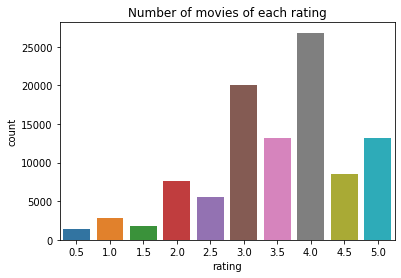

In [0]:
## get statistics for ratings
ratings_result=ratings_df.groupBy('rating').count()\
.withColumn('rating', ratings_df.rating.cast('float'))\
.toPandas()

fig = plt.figure()
tmp=sns.barplot(x='rating', y='count', data=ratings_result)
tmp.set_title('Number of movies of each rating')
display(tmp)

In [0]:
rated_list=ratings_df.select(ratings_df.movieId)\
.where('rating is not null')\
.withColumnRenamed('movieId', 'rated').distinct()

unrated_list=movies_df.join(rated_list, movies_df.movieId==rated_list.rated, "left_outer")\
.where('rated is null')

print('{} movies are unrated, {} movies are rated'.format(unrated_list.count(), rated_list.count()))

unrated_list.toPandas().fillna('No')

18 movies are unrated, 9724 movies are rated
Out[30]:

,movieId,title,genres,rated
0,1076,"Innocents, The (1961)",Drama|Horror|Thriller,No
1,2939,Niagara (1953),Drama|Thriller,No
2,3338,For All Mankind (1989),Documentary,No
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama,No
4,4194,I Know Where I'm Going! (1945),Drama|Romance|War,No
5,5721,"Chosen, The (1981)",Drama,No
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance,No
7,6849,Scrooge (1970),Drama|Fantasy|Musical,No
8,7020,Proof (1991),Comedy|Drama|Romance,No
9,7792,"Parallax View, The (1974)",Thriller,No


In [0]:
## compute sparsity
tmp=ratings_df.count()
print('sparsity is: {}'.format(1-tmp/9724/610))

sparsity is: 0.9830003169443864

## Part 2: Spark ALS based approach for training model

In [0]:
ratings_df.show(5)

# Data type conversion
movie_ratings=ratings_df.drop('timestamp')
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [0]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2], seed=1)

#Create ALS model
MR_ALS = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

#Define evaluator as RMSE
RMSE_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

#Tune model using ParamGridBuilder
paramgrid=ParamGridBuilder()\
.addGrid(MR_ALS.maxIter, [5])\
.addGrid(MR_ALS.rank, [2, 3, 4])\
.addGrid(MR_ALS.regParam, [0.03, 0.1, 0.3])\
.build()

# Build Cross validation 
crossval=CrossValidator(estimator=MR_ALS,
                        estimatorParamMaps=paramgrid,
                        evaluator=RMSE_evaluator,
                        numFolds=5, collectSubModels=True, seed=1)

#Fit ALS model to training data
cv_model=crossval.fit(training)

#Choose best model from the tuning exercise using ParamGridBuilder
best_model=cv_model.bestModel

#Print best model parameters
print ("**Best Model**")
print (" Rank:"+str(best_model.rank))
print (" MaxIter:"+str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:"+str(best_model._java_obj.parent().getRegParam()))

**Best Model**
 Rank:4
 MaxIter:5
 RegParam:0.1

In [0]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(test)
rmse = RMSE_evaluator.evaluate(predictions)
print ("RMSE = "+str(rmse))

RMSE = 0.871604656375358

In [0]:
# re-fitting using best parameters and whole data set
MR_ALS = ALS(maxIter=10, regParam=0.01, rank=3,userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
best_model=MR_ALS.fit(movie_ratings)

##Part 3: Model apply and performance

In [0]:
#extract all data
alldata=best_model.transform(movie_ratings)
rmse = RMSE_evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

#round predictions to 0.5
alldata=alldata.withColumn('rounded_predictions', F.round(F.col('prediction')*2)/2)
alldata_temp=alldata.toPandas()
alldata_temp.head()

RMSE = 0.6908832596777903
Out[37]:

,userId,movieId,rating,prediction,rounded_predictions
0,463,1088,3.5,3.865886,4.0
1,137,1580,3.5,3.415304,3.5
2,580,1580,4.0,3.833385,4.0
3,580,3175,2.5,4.058755,4.0
4,580,44022,3.5,3.592507,3.5


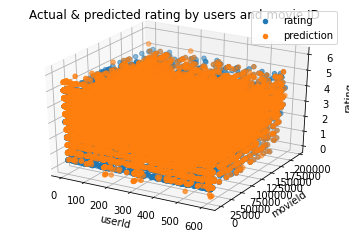

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=alldata_temp['userId']
y=alldata_temp['movieId']
z=alldata_temp['rating']
z1=alldata_temp['rounded_predictions']
ax.scatter(x, y, z, label='rating')
ax.scatter(x, y, z1, label='prediction')
ax.legend()
ax.set_xlabel('userId')
ax.set_ylabel('movieId')
ax.set_zlabel('rating')
ax.set_title('Actual & predicted rating by users and movie ID')
display(fig)

In [0]:
#plot actual and predicted ratings for movie with most number of ratings
movie_rated_most=alldata.where('movieId = 356').select('rating', 'rounded_predictions').orderBy('rating')

In [0]:
RMSE_evaluator_rounded = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="rounded_predictions")
print(RMSE_evaluator_rounded.evaluate(movie_rated_most))

0.7624349092751846

In [0]:
movie_rated_most=movie_rated_most.toPandas()

In [0]:
abs(movie_rated_most.rounded_predictions-movie_rated_most.rating).mean()

Out[42]: 0.5790273556231003

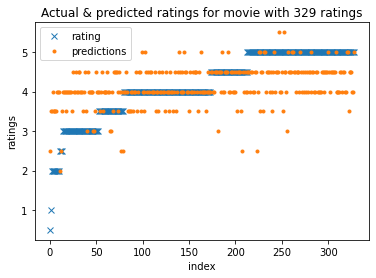

In [0]:
fig = plt.figure()
plt.plot(movie_rated_most.index, movie_rated_most.rating, 'x', label='rating')
plt.plot(movie_rated_most.index, movie_rated_most.rounded_predictions, '.', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for movie with 329 ratings')
display(fig)

In [0]:
#plot actual and predicted ratings for movie with 1 ratings
movie_rated_least=alldata.join(movies_result, movies_result.movieId==alldata.movieId, 'left')\
.where('count=1').select('rating', 'rounded_predictions').orderBy('rating')

In [0]:
print(RMSE_evaluator_rounded.evaluate(movie_rated_least))

0.020863539719116295

In [0]:
movie_rated_least=movie_rated_least.toPandas()

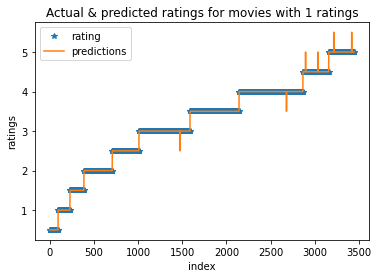

In [0]:
fig = plt.figure()
plt.plot(movie_rated_least.index, movie_rated_least.rating, '*', label='rating')
plt.plot(movie_rated_least.index, movie_rated_least.rounded_predictions, '-', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for movies with 1 ratings')
display(fig)

In [0]:
#plot actual and predicted ratings for most active user
user_rate_most=alldata.where('userId = 414').select('rating', 'rounded_predictions').orderBy('rating')

In [0]:
print(RMSE_evaluator_rounded.evaluate(user_rate_most))

0.5737008723037946

In [0]:
user_rate_most=user_rate_most.toPandas()

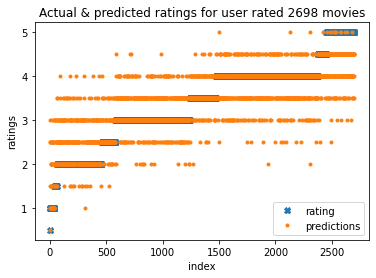

In [0]:
fig = plt.figure()
plt.plot(user_rate_most.index, user_rate_most.rating, 'X', label='rating')
plt.plot(user_rate_most.index, user_rate_most.rounded_predictions, '.', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for user rated 2698 movies')
display(fig)

In [0]:
#plot actual and predicted ratings for least active user
user_pool=users_result.where('count=20').toPandas()['userId'].tolist()
user_rate_least=alldata.where(alldata.movieId.isin(user_pool)).select('rating', 'rounded_predictions').orderBy('rating')

In [0]:
print(RMSE_evaluator_rounded.evaluate(user_rate_least))

0.7592289321598403

In [0]:
user_rate_least=user_rate_least.toPandas()

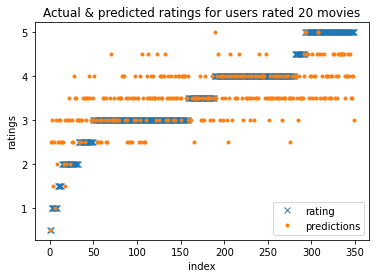

In [0]:
fig = plt.figure()
plt.plot(user_rate_least.index, user_rate_least.rating, 'x', label='rating')
plt.plot(user_rate_least.index, user_rate_least.rounded_predictions, '.', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for users rated 20 movies')
display(fig)

In [0]:
#plot average abs error by each movie and number of ratings
average_by_movie=alldata.groupBy('movieId')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBM'), F.count('rating').alias('number_of_users_rated'))\
.orderBy('MEBM', ascending=False)

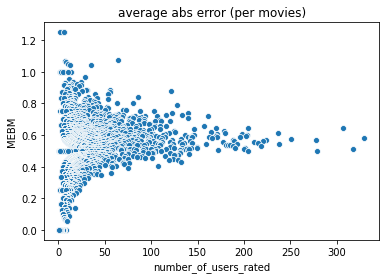

In [0]:
tmp=average_by_movie.toPandas()
fig = plt.figure()
tmp=sns.scatterplot(x='number_of_users_rated', y='MEBM', data=tmp)
tmp.set_title('average abs error (per movies)')
display(tmp)

In [0]:
#plot average abs error by number of ratings
average_by_rating_number=alldata.join(movies_result, movies_result.movieId==alldata.movieId, 'left')\
.groupBy('count')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBC'))\
.orderBy('count', ascending=False)

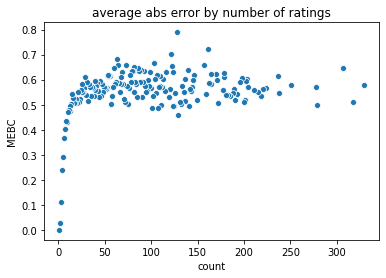

In [0]:
tmp=average_by_rating_number.toPandas()
fig = plt.figure()
tmp=sns.scatterplot(x='count', y='MEBC', data=tmp)
tmp.set_title('average abs error by number of ratings')
display(tmp)

## Part 4: Applications

In [0]:
user_list=set(['575', '232'])

recommend_for_all=best_model.recommendForAllUsers(5)

recommend_5=recommend_for_all.where(recommend_for_all.userId.isin(user_list))\
.select('userId', F.explode('recommendations'))\
.select('userId', F.col('col').movieId.alias('movieId'), F.col('col').rating.alias('rating'))

recommend_5=recommend_5.join(movies_df, recommend_5.movieId==movies_df.movieId, 'left')\
.select('userId', movies_df.movieId, 'title','genres')

recommend_5=recommend_5.join(movies_result, recommend_5.movieId==movies_result.movieId, 'left')

recommend_5.show()

+------+-------+--------------------+--------------------+-------+-----+
userId|movieId| title| genres|movieId|count|
+------+-------+--------------------+--------------------+-------+-----+
 232| 2068|Fanny and Alexand...|Drama|Fantasy|Mys...| 2068| 2|
 232| 159858|The Conjuring 2 (...| Horror| 159858| 2|
 232| 42730| Glory Road (2006)| Drama| 42730| 2|
 232| 2899|Gulliver's Travel...|Adventure|Animati...| 2899| 3|
 232| 2295|Impostors, The (1...| Comedy| 2295| 2|
 575| 2068|Fanny and Alexand...|Drama|Fantasy|Mys...| 2068| 2|
 575| 2327|Tales from the Da...|Fantasy|Horror|Th...| 2327| 3|
 575| 156726| Hush (2016)| Thriller| 156726| 3|
 575| 100083| Movie 43 (2013)| Comedy| 100083| 3|
 575| 95182|Dragon Ball Z the...|Action|Adventure|...| 95182| 2|
+------+-------+--------------------+--------------------+-------+-----+

In [0]:
all_movie_id=ratings_df.select('movieId').distinct()
is_rated=all_movie_id.where('movieId=471').count()==1

print('Movie with id 471 was rated? {}'.format(is_rated))

Movie with id 471 was rated? True

In [0]:
tmp_compare=best_model.itemFactors

compare=tmp_compare.select('id', 'features').where('id = 471').withColumnRenamed('id', 'id1').withColumnRenamed('features', 'f1')\
.crossJoin(tmp_compare.select('id', 'features').where('id != 471').withColumnRenamed('id', 'id2').withColumnRenamed('features', 'f2'))

In [0]:
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
cosine=udf(cos_sim, FloatType())

In [0]:
result=compare.withColumn('similarity', cosine(F.col('f1'), F.col('f2'))).where('similarity>0.999').orderBy('similarity', ascending=False)
result=result.join(movies_df, movies_df.movieId==result.id2,'left').select('title','genres')
result.show()

+--------------------+--------------------+
 title| genres|
+--------------------+--------------------+
 Sleuth (1972)|Comedy|Mystery|Th...|
 Ulee's Gold (1997)| Drama|
Legend, The (Lege...| Action|Comedy|
Adventures of Pri...| Comedy|Drama|
 Youngblood (1986)| Action|Drama|
 Woyzeck (1979)| Drama|
Mighty Wind, A (2...| Comedy|Musical|
The Hobbit: The B...| Adventure|Fantasy|
 Gettysburg (1993)| Drama|War|
 9 (2009)|Adventure|Animati...|
 Cake (2014)| Drama|
Pink Floyd: The W...| Drama|Musical|
Dead Snow 2: Red ...|Action|Comedy|Horror|
+--------------------+--------------------+

In [0]:
all_movie_id=ratings_df.select('movieId').distinct()
is_rated=all_movie_id.where('movieId=463').count()==1

print('Movie with id 463 was rated? {}'.format(is_rated))

Movie with id 463 was rated? False

In [0]:
average_by_user=alldata.groupBy('userId')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBU'), F.count('rating').alias('number_of_movies_rated'))\
.orderBy('MEBU', ascending=False)

In [0]:
average_by_user.where('MEBU>0.5').show()

+------+------------------+----------------------+
userId| MEBU|number_of_movies_rated|
+------+------------------+----------------------+
 308|1.1956521739130435| 115|
 77|1.1724137931034482| 29|
 461|1.0925925925925926| 27|
 153| 1.047486033519553| 179|
 112|1.0384615384615385| 65|
 467|0.9545454545454546| 22|
 344|0.9420289855072463| 69|
 542|0.9292035398230089| 113|
 76|0.9285714285714286| 119|
 147| 0.925| 20|
 598|0.9047619047619048| 21|
 426|0.9034090909090909| 88|
 517| 0.8775| 400|
 399|0.8472222222222222| 36|
 259|0.8448275862068966| 29|
 313|0.8308823529411765| 340|
 149|0.8275862068965517| 58|
 328|0.8274509803921568| 255|
 81|0.8269230769230769| 26|
 497|0.8235294117647058| 51|
+------+------------------+----------------------+
only showing top 20 rows